<a href="https://colab.research.google.com/github/Mainakdeb/deceptive-digits/blob/main/deceptive-digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn


import numpy as np
import matplotlib.pyplot as plt

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 2
batch_size = 64
image_size = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
lr = 2e-4
beta1 = 0.5
ngpu = 1

transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.RandomRotation(25),
     transforms.ToTensor(),
     transforms.Normalize(
         [0.5 for _ in range(nc)], 
         [0.5 for _ in range(nc)]
         )
    ]
)

dataset = datasets.MNIST(root="/dataset/", train=True, transform=transforms, download=True)

dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True, drop_last=True)

In [34]:
device

device(type='cuda')

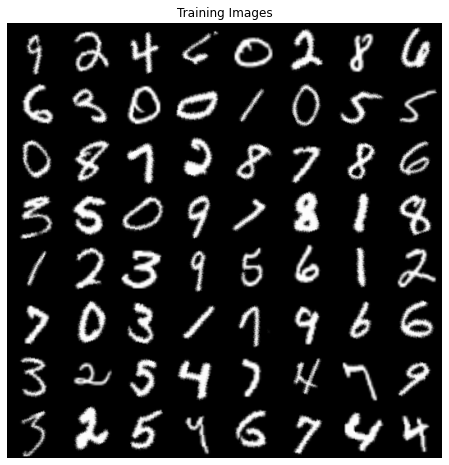

In [35]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [37]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        #meta data (label)    
        self.label_emb = nn.Embedding(10, 10)

        # Input is the latent vector Z.
        self.tconv1 = nn.ConvTranspose2d(nz+10, ngf*8,
            kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)

        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(ngf*8, ngf*4,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)

        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(ngf*4, ngf*2,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)

        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(ngf*2, ngf,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        
        # # Input Dimension: (ngf*2) x 16 x 16
        # self.tconv5 = nn.ConvTranspose2d(ngf, ngf,
        #     4, 2, 1, bias=False)
        # self.bn5 = nn.BatchNorm2d(ngf)

        # Input Dimension: (ngf) * 32 * 32
        self.tconv6 = nn.ConvTranspose2d(ngf, nc,
            4, 2, 1, bias=False)
        #Output Dimension: (nc) x 64 x 64

    def forward(self, x, labels):
        c = self.label_emb(labels)
        c = c.unsqueeze(2).unsqueeze(3)

        #print(c.size())
        #print(x.size())
        x = torch.cat([x, c], 1)
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        #x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv6(x))

        return x

netG = Generator(ngpu).to(device)
print(netG)

Generator(
  (label_emb): Embedding(10, 10)
  (tconv1): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [38]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        #meta data (label)
        self.label_emb = nn.Embedding(10, 10)

        # Input Dimension: (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf,
            4, 2, 1, bias=False)

        # # Input Dimension: (nc) x 64 x 64
        # self.conv2 = nn.Conv2d(ndf, ndf,
        #     4, 2, 1, bias=False)
        # self.bn2 = nn.BatchNorm2d(ndf*1)

        # Input Dimension: (ndf) x 32 x 32
        self.conv3 = nn.Conv2d(ndf, ndf*2,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*2)

        # Input Dimension: (ndf*2) x 16 x 16
        self.conv4 = nn.Conv2d(ndf*2, ndf*4,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*4)

        # Input Dimension: (ndf*4) x 8 x 8
        self.conv5 = nn.Conv2d(ndf*4, ndf*8,
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        # Input Dimension: (ndf*8) x 4 x 4
        self.conv6 = nn.Conv2d(ndf*8, 10, 4, 1, 0, bias=False)

        self.fc1 = nn.Linear(20, 15)
        self.fc2 = nn.Linear(15, 1)

    def forward(self, x, labels):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        #print(x.size())
        #x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        #print(x.size())
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.leaky_relu(self.conv6(x))
        x = torch.flatten(x, 1)

        c = self.label_emb(labels)
        #print(x.size())
        #print(c.size())
        x = torch.cat([x, c], 1)
        #print(x.size())
        #print(c.size())
        x = F.leaky_relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        #print(x.size())

        return x

netD = Discriminator(ngpu).to(device)
print(netD)

Discriminator(
  (label_emb): Embedding(10, 10)
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=20, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=1, bias=True)
)


In [43]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (label_emb): Embedding(10, 10)
  (tconv1): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)